In [4]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import norm
from scipy.stats import gaussian_kde
from collections import defaultdict

In [5]:
# Set path to the current working directory
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'pointclouds-500')

# List all .xyz files in the directory
file_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.xyz')]

# looping over files list to extract xyz values
point_cloud = []
for file in file_paths:
    df = pd.read_csv(file, delimiter=" ", names=['x', 'y', 'z'])
    x_values = df['x'].values
    y_values = df['y'].values
    z_values = df['z'].values
    point_cloud.append(np.column_stack((x_values, y_values, z_values)))

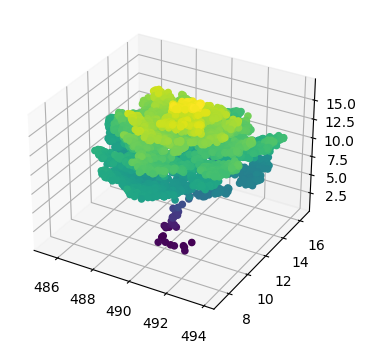

In [6]:
# visualise elements individually in 3D space (optional)
t = int(input("Object visualization query: "))  # the item no. for 3D viz
x_data = point_cloud[t][:, 0]
y_data = point_cloud[t][:, 1]
z_data = point_cloud[t][:, 2]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, c=z_data, alpha=1)
plt.show()


In [7]:
class Features:
    """
    Class to calculate various features from a list of objects and create a DataFrame with the results.

    Parameters:
    - objects (list): List of objects containing x, y, and z coordinates.

    Usage:
    - Initialize the class with a list of objects.
    - Call the initialize method to calculate features and create the DataFrame.
    """

    def __init__(self, objects):
        self.objects = objects
        self.initialize()
        
    def max_height(self, z):
        """Calculate the maximum height from a list of z coordinates."""
        return max(z)

    def ground_area(self, x, y):
        """Calculate the ground area from lists of x and y coordinates."""
        return (max(x) - min(x)) * (max(y) - min(y))
    
    def density(self, x, y, z, n_points):
        """Calculate the density based on the volume and number of points."""
        volume = ((max(x) - min(x)) * (max(y) - min(y)) * (max(z) - min(z)))
        return volume / n_points
    
    def get_areas(self, X, Y):
        """Calculate the projected bounding box ratio."""
        X_rounded = [round(x) for x in X]
        Y_rounded = [round(y) for y in Y]
        x_max, x_min, y_max, y_min = max(X_rounded), min(X_rounded), max(Y_rounded), min(Y_rounded)
        x_max, x_min = x_max + 0.5, x_min - 0.5
        y_max, y_min = y_max + 0.5, y_min - 0.5
        bb_len, bb_width = abs(x_max - x_min), abs(y_max - y_min)
        bb_area = bb_len * bb_width
        if bb_area == 0:
            print(y_max, y_min)
        
        string_repr = set([','.join([str(x), str(y)]) for x, y in zip(X_rounded, Y_rounded)])
        projected_area = len(string_repr)
        ratio_bb = projected_area / (bb_area * 100)
        return ratio_bb
    
    def average_height(self, z):
        """Calculate the average height from a list of z coordinates."""
        return np.mean(z)

    def planarity(self, x, y, z):
        """Calculate the planarity of the object."""
        cov = np.cov(np.array([x, y, z]))
        eigenval, eigenvect = np.linalg.eig(cov)
        eigenval.sort()
        return (eigenval[1] + eigenval[0]) / (eigenval[0] + eigenval[1] + eigenval[2])

    def extract_xyz(self, cloud):
        """Extract x, y, and z coordinates from a list of points."""
        x, y, z = [], [], []
        for point in cloud:
            x.append(point[0])
            y.append(point[1])
            z.append(point[2])
        n_points = len(x)
        return x, y, z, n_points
        
    def calc_all_features(self):
        """
        Calculate all features for each object and return a DataFrame.

        Returns:
        - df (DataFrame): DataFrame containing calculated features.
        """
        features_dict = defaultdict(list)
        for item in self.objects:
            x, y, z, n_points = self.extract_xyz(item)
            features_dict['max_heights'].append(self.max_height(z))
            features_dict['ground_area'].append(self.ground_area(x, y))
            features_dict['density'].append(self.density(x, y, z, n_points))
            features_dict['projected_bb'].append(self.get_areas(x, y))
            features_dict['average_height'].append(self.average_height(z))
            features_dict['planarity'].append(self.planarity(x, y, z))
            
        return pd.DataFrame(features_dict)
    
    def initialize(self):
        """
        Initialize the class and calculate features, and assign labels to the DataFrame.
        """
        df = self.calc_all_features()
        df['label'] = ''
        df['label'][0:100] = 'building'
        df['label'][100:200] = 'car'
        df['label'][200:300] = 'fence'
        df['label'][300:400] = 'pole'
        df['label'][400:500] = 'tree'
        self.df = df

In [8]:
features = Features(point_cloud)
display(features.df)
df_features = features.df

C:\Users\ppant\AppData\Local\Temp\ipykernel_5064\2656919683.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][0:100] = 'building'
C:\Users\ppant\AppData\Local\Temp\ipykernel_5064\2656919683.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][100:200] = 'car'
C:\Users\ppant\AppData\Local\Temp\ipykernel_5064\2656919683.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][200:300] = 'fence'
C:\Users

,max_heights,ground_area,density,projected_bb,average_height,planarity,label
0,19.730000,48.731934,0.135232,0.009167,18.003383,0.199947,building
1,8.470000,64.715485,0.112223,0.007857,7.385178,0.308227,building
2,15.570000,273.662312,0.228969,0.008301,12.986387,0.419449,building
3,16.469999,354.430061,0.243781,0.007247,13.856272,0.397191,building
4,9.750000,520.882345,0.223818,0.006174,7.823214,0.364260,building
...,...,...,...,...,...,...,...
495,11.540000,40.565323,0.106486,0.007500,7.438339,0.580601,tree
496,15.170000,106.506569,0.198018,0.007197,9.659321,0.561576,tree
497,11.110000,36.537662,0.213788,0.007708,7.443952,0.389778,tree
498,18.910000,40.327366,0.228704,0.008000,12.962448,0.455015,tree


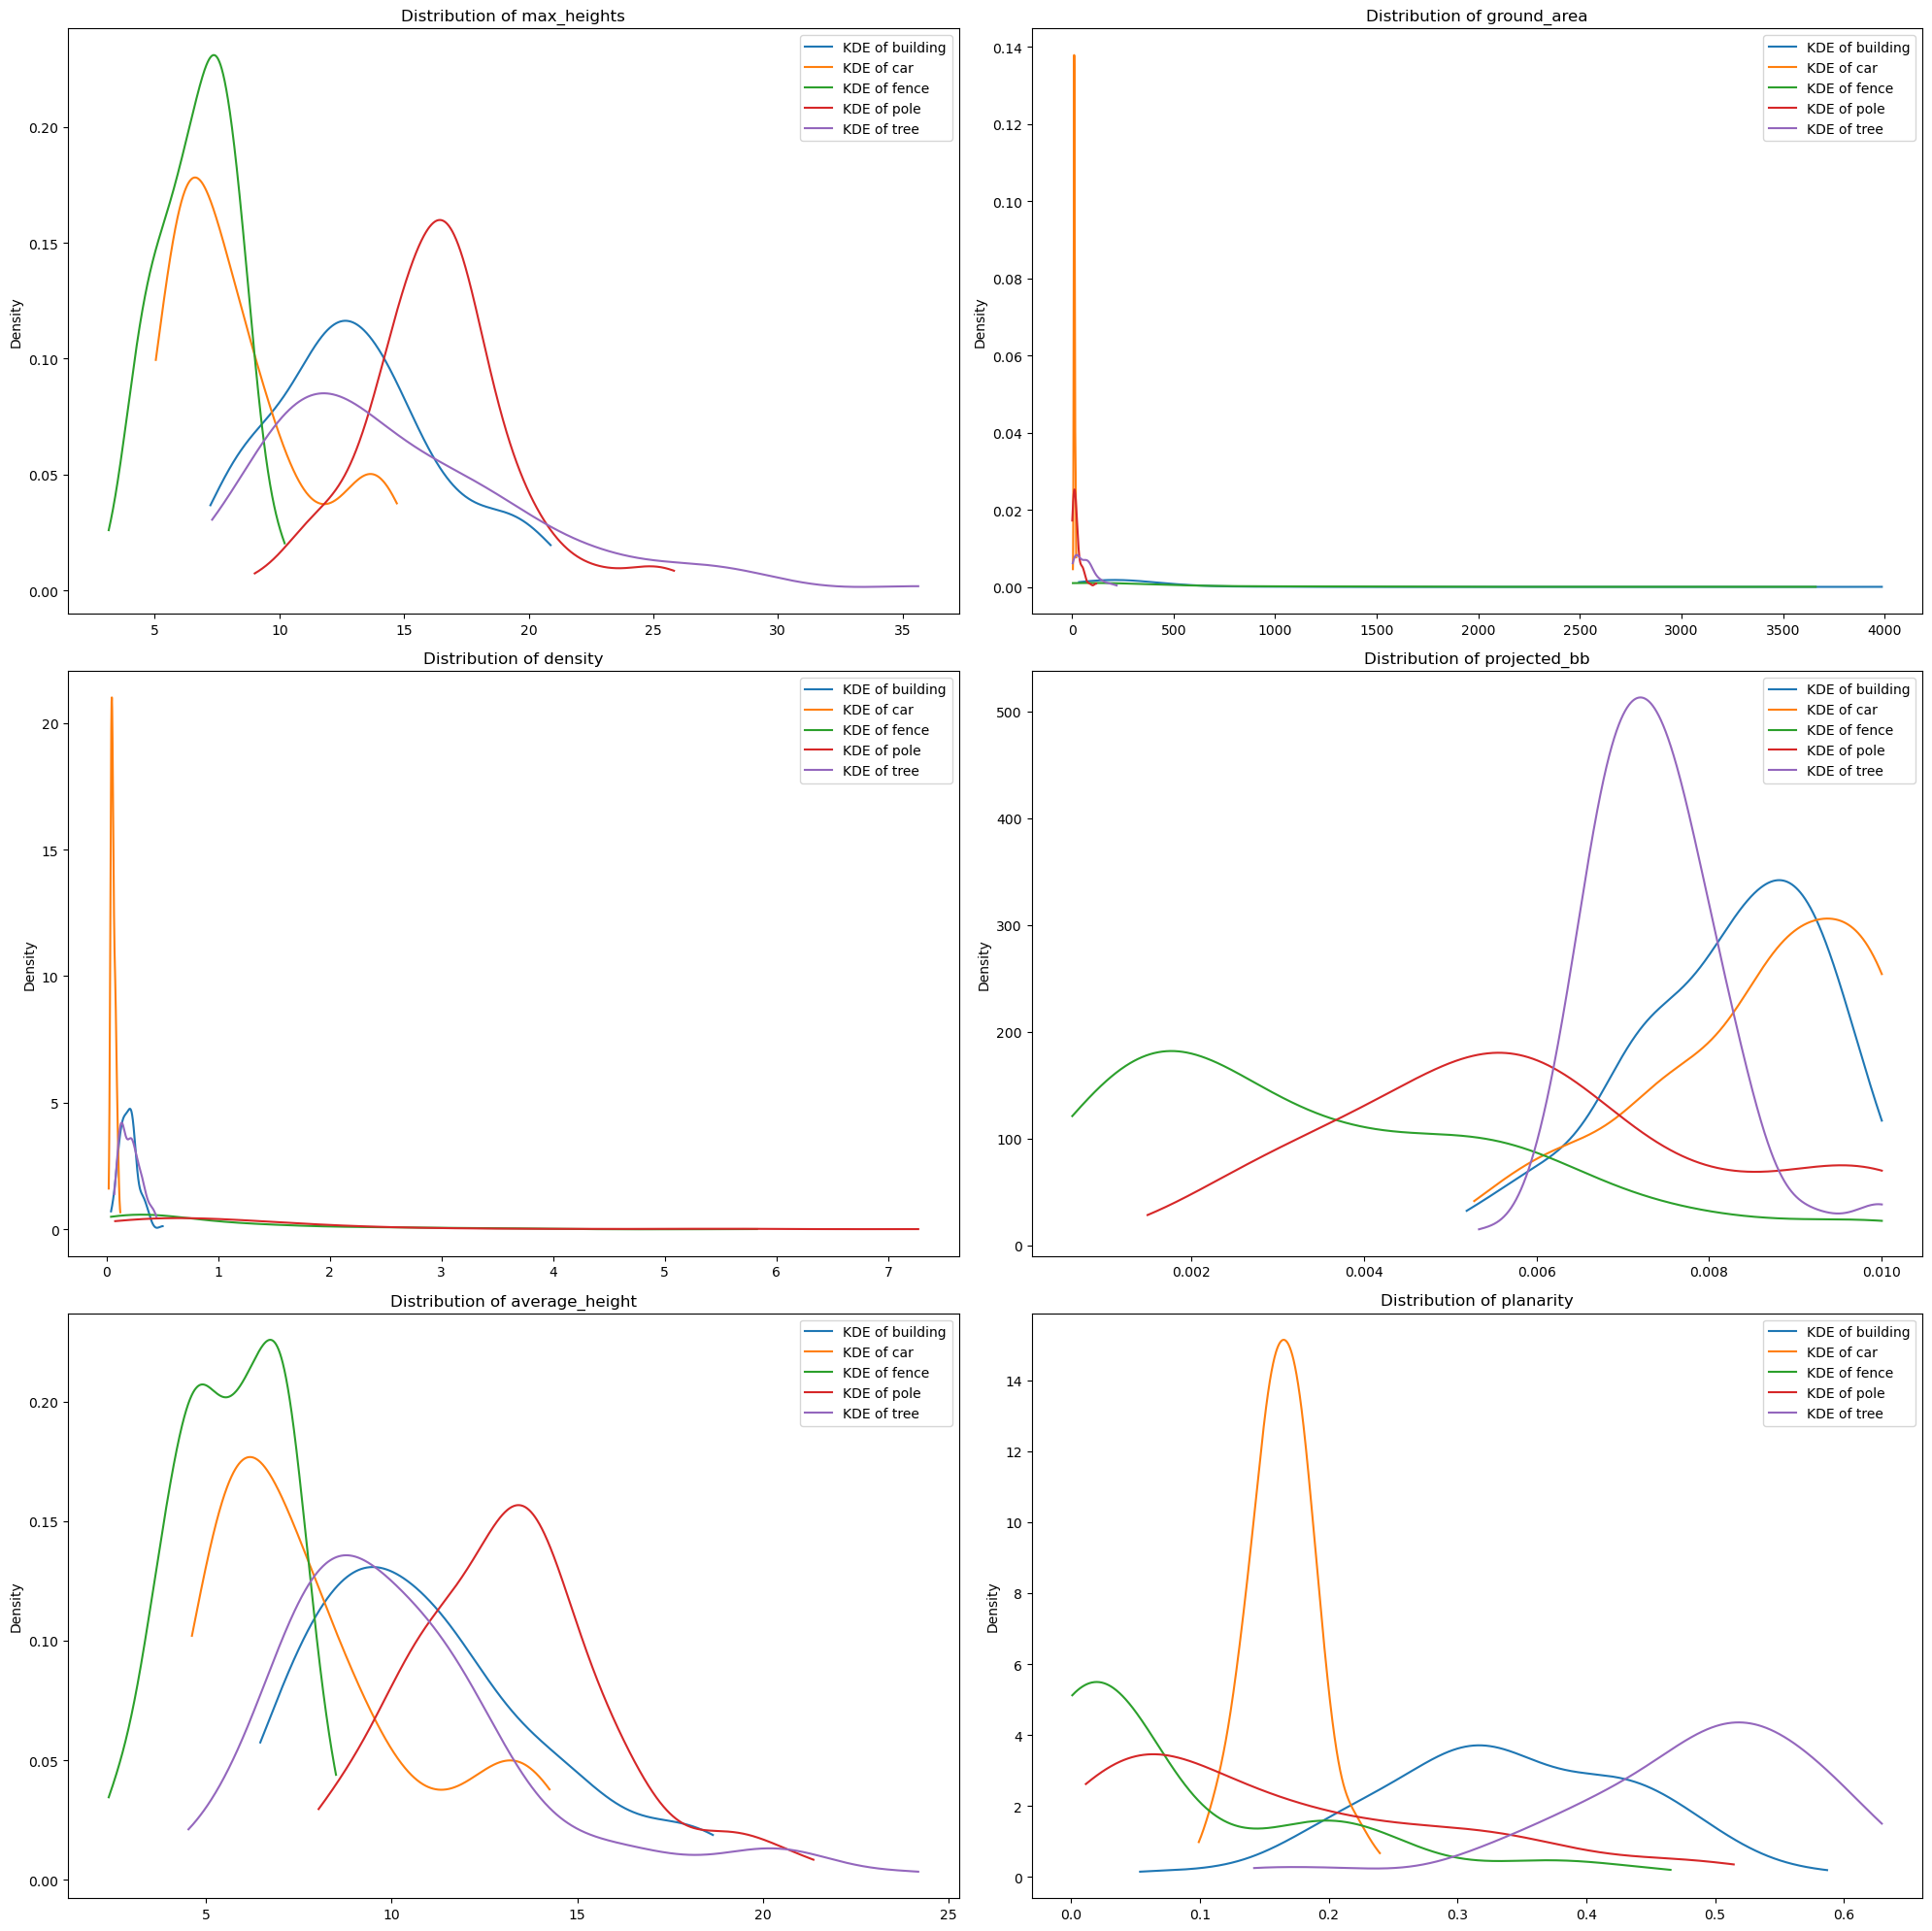

In [9]:
def distributions(dataframe):
    """
    Plot distributions of features for each class in the given DataFrame.

    Parameters:
    - dataframe (DataFrame): DataFrame containing features and labels.

    Usage:
    - Call this function with the DataFrame containing features and labels to plot distributions.
    """
    # Create subplots based on the number of features
    fig, axs = plt.subplots(int(np.ceil((dataframe.shape[1] - 1) / 2)), 2, figsize=(20, 20))
    
    # Get unique class names
    class_names = dataframe['label'].unique()
    
    # Iterate over subplots
    for i, ax in enumerate(axs.flatten()):
        # Stop plotting if all features have been plotted
        if i >= dataframe.shape[1] - 1:
            break
            
        # Get the name of the feature to plot
        feature_name = dataframe.columns[i]
        
        # Plot KDE for each class
        for class_name in class_names:
            # Select data points for the current class
            data = dataframe.loc[dataframe['label'] == class_name, feature_name]
            
            # Calculate KDE
            kde = gaussian_kde(data)
            
            # Generate x values for plotting
            x = np.linspace(data.min(), data.max(), 1000)
            
            # Plot KDE
            ax.plot(x, kde(x), label=f'KDE of {class_name}')

            # OPTIONAL Plot pdf
            # mean, std_dev = np.mean(data), np.std(data)
            # pdf = norm.pdf(x, loc=mean, scale=std_dev)
            # ax.plot(x, pdf, label=f'pdf of {class_name}')
            
            # OPTIONAL Plot histogram
            # ax.hist(data, bins=20, density=True, label=f'histogram of {class_name}')
        
        # Set title and labels
        ax.set_title(f'Distribution of {feature_name}')
        ax.legend()
        ax.set_ylabel('Density')
        
    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

distributions(df_features)

In [10]:
def plot_pointclouds(dataframe, feature1, feature2):
    """
    Plot point clouds for each class in the given dataframe.

    Parameters:
        dataframe (DataFrame): The dataframe containing the data.
        feature1 (str): The name of the feature to plot on the x-axis.
        feature2 (str): The name of the feature to plot on the y-axis.
        
    """
    # Iterate over unique classes in the dataframe
    for class_label in dataframe['label'].unique():
        # Select data points for the current class
        class_data = dataframe[dataframe['label'] == class_label]
        
        # Scatter plot for the current class
        plt.scatter(class_data[feature1], class_data[feature2], label=class_label)

    # Add labels and title
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'Point Clouds Comparison: {feature1} vs {feature2}')
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()

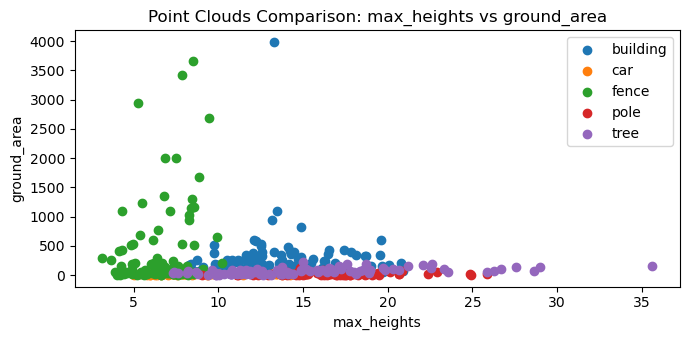

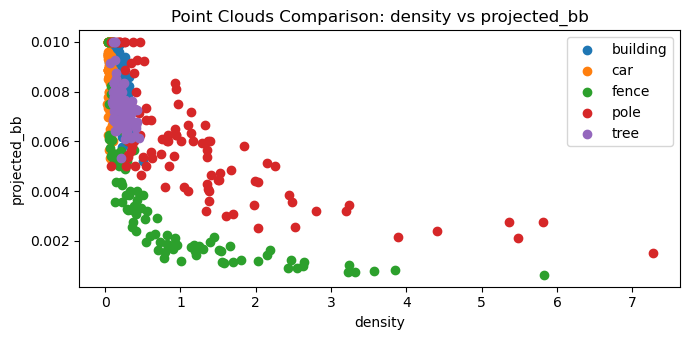

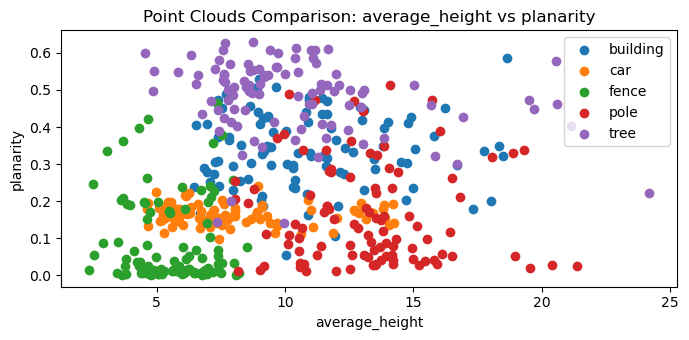

In [11]:
plot_pointclouds(df_features, 'max_heights', 'ground_area')
plot_pointclouds(df_features, 'density', 'projected_bb')
plot_pointclouds(df_features, 'average_height', 'planarity')



In [12]:
# separate the df_features (X) and labels (y) to train and test the model
X = df_features.drop('label', axis=1)
y = df_features['label']


In [13]:
def SVM_classifier(x_data, y_data, test_size, kernel, C=1, max_iter=-1, decision_func_shape='ovr', class_weight=None, random_state=42, feat_importance=False, svm_metrics=False, confusion_mat=False):
    """
    Train and evaluate a Support Vector Machine (SVM) classifier.

    Args:
    - x_data (DataFrame): Input features.
    - y_data (Series): Target labels.
    - test_size (float): Proportion of the dataset to include in the test split.
    - kernel (str): Specifies the kernel type to be used in the algorithm.
    - C (float, optional): Regularization parameter. Defaults to 1.
    - max_iter (int, optional): Hard limit on iterations within solver. Defaults to -1.
    - decision_func_shape (str, optional): Shape of decision function. Defaults to 'ovr'.
    - random_state (int, optional): Random seed. Defaults to 42.

    Returns:
    - accuracy (float): Accuracy of the classifier.
    - mean_class_acc (float): Mean per class accuracy of the classifier.
    """
    # Split train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)

    # Scale input data
    scale_features = StandardScaler()
    X_train = scale_features.fit_transform(X_train)
    X_test = scale_features.transform(X_test)

    # Train SVM model
    classifier = svm.SVC(C=C, kernel=kernel, gamma='scale', max_iter=max_iter, decision_function_shape=decision_func_shape, class_weight=class_weight, random_state=random_state)
    classifier.fit(X_train, y_train)

    # Predict using trained model
    y_hat = classifier.predict(X_test)

    # Evaluate classifier
    accuracy = accuracy_score(y_test, y_hat)
    class_acc = classification_report(y_test, y_hat, digits=3, zero_division=1, output_dict=True)

    # Compute mean per class accuracy
    class_names = y_test.unique()
    correct = 0 
    y_test_array = y_test.values
    for i in range(len(class_names)):
        correct_class = 0
        indexes = np.where(y_test_array == class_names[i])
        indexes = indexes[0]
        for index in indexes:          
            if y_hat[index] == class_names[i]:
                correct_class += 1
        acc_class = correct_class/len(indexes)
        correct += acc_class
        
    mean_class_acc = np.round(correct/len(class_names), 3)
    
    if feat_importance == True:

        # feature importance for svm
        feature_importance = permutation_importance(classifier, X_test, y_test)
        feature_names = np.array(x_data.columns.unique())
        sorted_idx = feature_importance.importances_mean.argsort()
        feat_svm = feature_names[sorted_idx]
        score_svm = feature_importance.importances_mean[sorted_idx]

        # Print feature names and their importance's in a sorted list
        print("Feature Importance of SVM:")
        for i in range(len(feat_svm)):
            print(f"{feat_svm[i]}: {round(score_svm[i],3)}")
        print()

    if svm_metrics == True:
        print('svm report: ')
        print(classification_report(y_test, y_hat, digits=3, zero_division=1))

    if confusion_mat ==True:
        # create confusion matrix with y_hat and y_test
        # confusion matrix compares values from y_hat with y_test using sklearn.metrics
        # confusion matrix shows True positive(TP), False positive(FP), True negative(TN), False negative(FN)
        # https://www.v7labs.com/blog/confusion-matrix-guide
        conf_matrix = confusion_matrix(y_pred=y_hat, y_true=y_test)
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        # Build the plot through heatmap
        plt.figure(figsize=(16, 7))
        sns.set(font_scale=1.4)
        
        sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10},
                    cmap=plt.cm.Blues, linewidths=0.2, xticklabels=class_names, yticklabels=class_names)

        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix for SVM Model')
        plt.show()

    return accuracy, mean_class_acc

In [14]:
{'building': 1, 'car':10, 'fence':1, 'pole':1, 'tree':10} 
accuracy, mean_accuracy = SVM_classifier(X, y, 0.2, 'rbf', C=3,class_weight='balanced')
print(accuracy, mean_accuracy)

0.97 0.965


In [22]:

C_list = [0.1, 0.25, 0.5, 1, 1.5, 2, 5, 10]
kernel_list = ['poly', 'rbf', 'sigmoid']
class_weight = [None, 'balanced', {'building': 10, 'car':1, 'fence':1, 'pole':1, 'tree':1},
                {'building': 1, 'car':10, 'fence':1, 'pole':1, 'tree':1},
                {'building': 1, 'car':1, 'fence':10, 'pole':1, 'tree':1},
                {'building': 1, 'car':1, 'fence':1, 'pole':10, 'tree':1},
                {'building': 1, 'car':1, 'fence':1, 'pole':1, 'tree':10}]
max_iter = [-1, 500, 1000, 5000]
decisionfunctionshape = ['ovo', 'ovr']

accuracy_list = [0]
mean_accuracy_list = [0]
for c in C_list:
    for kernel in kernel_list:
        for weight in class_weight:
            for max_i in max_iter:
                for dec_shape in decisionfunctionshape:
                    accuracy, mean_accuracy = SVM_classifier(X, y, 0.2, kernel, C=c, max_iter=max_i, decision_func_shape=dec_shape, class_weight=weight)
                    
                    if accuracy > max(accuracy_list):
                        accuracy_max = accuracy
                        best_C, best_kernel, best_max_i, best_dec_shape, best_weight = c, kernel, max_i, dec_shape, weight
                        
                    if mean_accuracy > max(mean_accuracy_list):
                        mean_accuracy_max = mean_accuracy
                        mbest_C, mbest_kernel, mbest_max_i, mbest_dec_shape, mbest_weight = c, kernel, max_i, dec_shape, weight
                    
                    accuracy_list.append(accuracy)
                    mean_accuracy_list.append(mean_accuracy)
                    
print(f'The best accuracy is {accuracy_max} with:\n C:{best_C}\n kernel:{best_kernel}\n maximum iterations:{best_max_i}\n decision function shape:{best_dec_shape}\n class weights:{best_weight}')
print(f'The best mean per class accuracy is {mean_accuracy_max} with: \n C:{best_C}\n kernel:{best_kernel}\n maximum iterations:{best_max_i}\n decision function shape:{best_dec_shape}\n class weights: {mbest_weight}')




c:\Users\ppant\anaconda3\envs\dsaie\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\ppant\anaconda3\envs\dsaie\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\ppant\anaconda3\envs\dsaie\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\ppant\anaconda3\envs\dsaie\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The best accuracy is 0.99 with:
 C:5
 kernel:rbf
 maximum iterations:-1
 decision function shape:ovo
 class weights:None
The best mean per class accuracy is 0.993 with: 
 C:5
 kernel:rbf
 maximum iterations:-1
 decision function shape:ovo
 class weights: None


In [23]:
def RF_classifier(x_data, y_data, test_size, n_estimators=100, criterion='gini', max_features='sqrt', 
                  bootstrap=True, max_samples=None, feat_importance=False, rf_metrics=False, 
                  confusion_mat=False, random_state=42):
    """
    Random Forest Classifier function for training and evaluating a Random Forest model.

    Parameters:
    - x_data (DataFrame or array-like): Input features.
    - y_data (Series or array-like): Target labels.
    - test_size (float): Proportion of the dataset to include in the test split.
    - n_estimators (int): Number of trees in the forest.
    - criterion (str): The function to measure the quality of a split.
    - max_features (str): The number of features to consider when looking for the best split.
    - bootstrap (bool): Whether bootstrap samples are used when building trees.
    - max_samples (int or float): The number of samples to draw from X to train each base estimator.
    - feat_importance (bool): Whether to print feature importance scores.
    - rf_metrics (bool): Whether to print evaluation metrics.
    - confusion_mat (bool): Whether to plot the confusion matrix.
    - random_state (int): Random state for reproducibility.

    Returns:
    - accuracy (float): Overall accuracy of the classifier.
    - mean_class_acc (float): Mean per-class accuracy.

    Usage:
    - Call this function to train and evaluate a Random Forest model on the given dataset.
    """
    # Split train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)
    
    # Initialize Random Forest classifier
    rf_func = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_features=max_features, 
                                     bootstrap=bootstrap, max_samples=max_samples, random_state=random_state, 
                                     oob_score=False)
    
    # Fit the classifier to the training data
    rf_func.fit(X_train, y_train)
    
    # Predictions on the test set
    y_hat_rf = rf_func.predict(X_test)

    # Calculate accuracy of the classifier
    accuracy = accuracy_score(y_test, y_hat_rf)

    # Calculate mean per-class accuracy
    class_names = y_test.unique()
    correct = 0 
    y_test_array = y_test.values
    for i in range(len(class_names)):
        correct_class = 0
        indexes = np.where(y_test_array == class_names[i])
        indexes = indexes[0]
        for index in indexes:          
            if y_hat_rf[index] == class_names[i]:
                correct_class += 1
        acc_class = correct_class / len(indexes)
        correct += acc_class
    mean_class_acc = np.round(correct / len(class_names), 3)
    
    if feat_importance:
        # Print feature importance
        importance = rf_func.feature_importances_
        for i, v in enumerate(importance):
            print(f'Feature importance: {i}, Score: {v:.5f}')

    if confusion_mat:
        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_pred=y_hat_rf, y_true=y_test)
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(16, 7))
        sns.set(font_scale=1.4)
        sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10}, cmap=plt.cm.Greens, 
                    linewidths=0.2, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix for Random Forest Model')
        plt.show()
    
    if rf_metrics:
        # Print classification report
        print('Random Forest Report:')
        print(classification_report(y_test, y_hat_rf, digits=3, zero_division=1))

    return accuracy, mean_class_acc



In [26]:
n_estimators = [10, 25, 50, 100, 200, 500, 1000]
criterion = ['gini', 'entropy', 'log_loss']
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]
max_samples = [0.1, 0.25, 0.5, 0.75, 1]

rf_accuracy_list = [0]
rf_mean_accuracy_list = [0]
for n_est in n_estimators:
    for crit in criterion:
        for max_f in max_features:
            for bootstr in bootstrap:
                for max_s in max_samples:
                    if bootstr == True:
                        accuracy, mean_accuracy = RF_classifier(X, y, 0.2, n_estimators=n_est, criterion=crit, max_features=max_f, bootstrap=bootstr, max_samples=max_s)
                    else:
                        accuracy, mean_accuracy = RF_classifier(X, y, 0.2, n_estimators=n_est, criterion=crit, max_features=max_f, bootstrap=bootstr)
                    
                    if accuracy > max(rf_accuracy_list):
                        rf_accuracy_max = accuracy
                        max_n_est, max_crit, max_max_f, max_bootstr, max_max_s = n_est, crit, max_f, bootstr, max_s
                    if mean_accuracy > max(rf_mean_accuracy_list):
                        rf_mean_accuracy_max = mean_accuracy
                        mmax_n_est, mmax_crit, mmax_max_f, mmax_bootstr, mmax_max_s = n_est, crit, max_f, bootstr, max_s
                    
                    rf_accuracy_list.append(accuracy)
                    rf_mean_accuracy_list.append(mean_accuracy)
print(f'The best accuracy is {rf_accuracy_max} with:\n number of estimators:{max_n_est}\n criterion:{max_crit}\n maximum features:{max_max_f}\n bootstrap:{max_bootstr}\n maximum samples:{max_max_s}')
print(f'The best mean per class accuracy is {rf_mean_accuracy_max} with:\n number of estimators:{mmax_n_est}\n criterion:{mmax_crit}\n maximum features:{mmax_max_f}\n bootstrap:{mmax_bootstr}\n maximum samples:{mmax_max_s}')

The best accuracy is 0.98 with:
 number of estimators:50
 criterion:entropy
 maximum features:None
 bootstrap:True
 maximum samples:0.25
The best mean per class accuracy is 0.986 with:
 number of estimators:50
 criterion:entropy
 maximum features:None
 bootstrap:True
 maximum samples:0.25
